First, establish an ssh tunnel [with your PNI password] to jtb3-dev.princeton.edu to make the database available to you:

    ssh username@jtb3-dev.princeton.edu -L 3306:127.0.0.1:3306 -N

jtb3-dev is the database server on which all behavior and mouse data is stored. Second, make sure you have installed datajoint >= '0.12.dev3'
[ pip install datajoint==0.12.dev3 ]

In [26]:
import pylab as pl
import datajoint as dj
import numpy as np
import os,sys
import secrets
assert dj.__version__>='0.12.dev3'
import pickle
from datetime import datetime
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
import pandas as pd
import pkg_resources

home_dir = os.environ['HOME']

In [4]:
schema = dj.schema('ahoag_lightsheet_demo') 

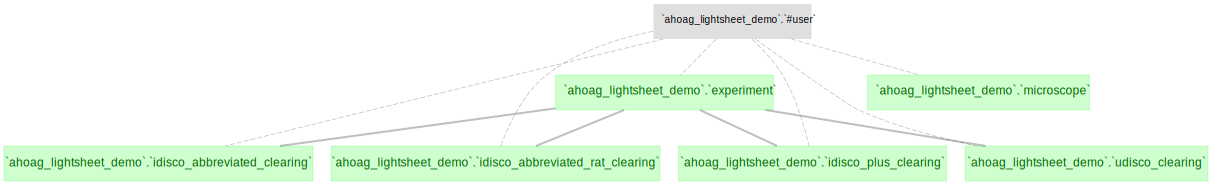

In [5]:
dj.ERD(schema)

## 1) Define database tables

In [19]:
@schema
class User(dj.Lookup):
    definition = """
    # Users of the light sheet microscope
    username : varchar(20)      # user in the lab
    ---
    email       : varchar(50)
    """
    
@schema
class Experiment(dj.Manual):
    definition = """ # Experiments performed using the light sheet microscope
    experiment_id           :   smallint auto_increment    # allowed here are sql datatypes.
    ----
    -> User 
    title                   :   varchar(100)
    description             :   varchar(250)
    notes = ""              :   varchar(1000)
    species                 :   varchar(50)
    clearing_protocol       :   enum("iDISCO+_immuno","iDISCO abbreviated clearing","iDISCO abbreviated clearing (rat)","uDISCO","iDISCO_EdU")
    clearing_progress       :   enum("incomplete","complete")
    fluorophores            :   varchar(100)
    antibody1               :   varchar(100)
    antibody2               :   varchar(100)
    image_resolution        :   enum("1.3x","4x")
    cell_detection          :   tinyint
    registration            :   tinyint
    probe_detection         :   tinyint
    injection_detection     :   tinyint
    """  
    
@schema #  
class Microscope(dj.Manual): # dj.Manual is one of the 4 datajoint table types - Manual corresponds to externally inputted data
    definition = """ # Periodic calibration data of the light sheet microscope
    entrynum                :   smallint auto_increment    # allowed here are sql datatypes.
    ----
    -> User              
    date                    :   varchar(10)    
    old_objective           :   varchar(50)
    new_objective           :   varchar(50)
    swapper                 :   varchar(250)
    calibration =           :   varchar(1000) 
    notes =                 :   varchar(1000)
    """

In [10]:
User()

username user in the lab,email
ahoag,ahoag@princeton.edu
apv2,apv2@princeton.edu
ejdennis,Ejdennis@princeton.edu
jverpeut,jverpeut@princeton.edu
marlies.oostland,marlies.oostland@princeton.edu
mioffe,mioffe@princeton.edu
pbibawi,pbibawi@princeton.edu
rmallarino,rmallarino@princeton.edu
soline,soline@princeton.edu
willmore,Willmore@princeton.edu


In [11]:
Experiment()

experiment_id allowed here are sql datatypes.,username user in the lab,title,description,notes,species,clearing_protocol,clearing_progress,fluorophores,antibody1,antibody2,image_resolution,cell_detection,registration,probe_detection,injection_detection
1,jverpeut,DREADDymaze,Image c-fos in whole brains at 1.3x.,,mouse,iDISCO+_immuno,complete,None,Anti cfos 1:1000,Donkey antirabbit AF647 1:200,1.3x,1,1,0,0
2,willmore,20190304_LW_m340,Detect placement of optical fiber tip,,mouse,iDISCO abbreviated clearing,complete,GCampxDat-Cre Double Transgentic Mouse,None,None,1.3x,0,1,1,0
3,jverpeut,an1-31,Recover mcherry expression in cerebellum. Morphology analysis.,,mouse,iDISCO+_immuno,complete,mcherry,rabbit anti-RFP 1:1000,Donkey antiRabbit 647 1:450,1.3x,0,1,0,1
4,apv2,20190313_IBL_DiI_1,Detection of CM DiI,,mouse,iDISCO abbreviated clearing,complete,CM DiI,NA,NA,4x,0,0,1,0
5,zmd,"20181217_marlies, 20181031_marlies_M12",recovery of electrode tract,Pilot,mouse,iDISCO abbreviated clearing,complete,N/A,N/A,N/A,1.3x,0,1,1,0
6,jverpeut,EAAT4- 14 samples,Look for cerebellar banding. GFP,,mouse,iDISCO+_immuno,complete,GFP,Chicken antiGFP Aves 1:1000,Donkey anti chicken 647 1:750,1.3x,1,1,0,0
7,mioffe,a1_20190327 a2_20190327 a3_20190327,"To check expression of gcamp in two animals (a1 and a2), and one opsin tagged with gfp (a3)",,mouse,iDISCO+_immuno,complete,"gcamp in a1 and a2, gfp in a3, which was injected with soCoChR-GFP",I don't know..,I don't know..,1.3x,0,1,0,1
8,jverpeut,LindsayCrusI_ymaze_cfos (25 samples),Detect c-fos.,,mouse,iDISCO+_immuno,complete,AlexaFluor 647,SySy Rb antiFos 1:1000,Donkey antiRabbit 647 1:200,1.3x,1,1,0,0
9,jverpeut,AdultChronicD_MLI_Lawrence (1-12 each batch),detect c-Fos,12 LobVI and 12 crusI,mouse,iDISCO+_immuno,complete,AlexaFluor 647,SySy Rb antiFos 1:1000,Donkey antiRabbit 647 1:200,1.3x,1,1,0,0
10,pbibawi,"20190405_pb_X015, 20190405_pb_X045, 20190405_pb_A233,20190405_pb_A232",Cell tracing and counting after CTB injection,,rat,iDISCO abbreviated clearing (rat),complete,AlexaFluor647 and AlexaFluor488,NONE,DONE,4x,1,1,0,1


In [20]:
Microscope()

entrynum allowed here are sql datatypes.,username user in the lab,date,old_objective,new_objective,swapper,calibration,notes


## 2) Download content for the database from existing google sheets and the Sheets API

In [32]:
def retrieve_google_sheet(spreadsheet_id,range_query):
    """
    ---PURPOSE---
    Get data from the range of cells in the google sheet specified.
    ---INPUT---
    spreadsheet_id    The long string in the URL of a google sheet
                      that identifies the sheet
    range_query       The Sheets API range query, e.g. 'Sheet1!A3:B3'
    """
    creds = None
    # The file token.pickle stores the user's access and refresh tokens, and is
    # created automatically when the authorization flow completes for the first
    # time.
    if os.path.exists('token.pickle'):
        with open('token.pickle', 'rb') as token:
            creds = pickle.load(token)
    # If there are no (valid) credentials available, let the user log in.
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(
                secrets_file, SCOPES)
            creds = flow.run_local_server(port=0)
        # Save the credentials for the next run
        with open('token.pickle', 'wb') as token:
            pickle.dump(creds, token)

    service = build('sheets', 'v4', credentials=creds)

    # Call the Sheets API
    sheet = service.spreadsheets()
    result = sheet.values().get(spreadsheetId=spreadsheet_id,
                                range=range_query).execute()
    values = result.get('values', [])

    return values

## Fill User and Experiment tables

In [33]:
# Grab the form response data so we can fill out User() and Experiment() table
# Set the scope to be read only since we are not adding anything to the google sheet, just reading it
SCOPES = ['https://www.googleapis.com/auth/spreadsheets.readonly']
# Set the spreadsheet ID (long string in the url, e.g.: 
# https://docs.google.com/spreadsheets/d/1YbP64yIApUaxjpscBXP8r82VmrkrKYakbjRFqF9XHB0/edit#gid=0) 
# As well as the range of cells you want to grab. 
SPREADSHEET_ID = '1A83HVyy1bEhctqArwt4EiT637M8wBxTFodobbt1jrXI' # The live clearing/form responses spreadsheet
# We are in readonly (see SCOPES) so we cannot destroy it by accident.
secrets_file = 'credentials.json' # Has to be called "credentials.json"  
assert os.path.exists(secrets_file)
range_query='Form Responses!B4:P36'
form_response_data = retrieve_google_sheet(spreadsheet_id=SPREADSHEET_ID,range_query=range_query)
# Remove "Number of Samples" column since it is empty and we don't want it
form_response_data=[x[0:3]+x[4:] for x in form_response_data]

In [34]:
today = datetime.now().strftime('%Y-%m-%d')
experiment_data_file = home_dir + f'/Git/lightserv_dj_demo/lightserv/data/experiment_data_{today}.pkl'
with open(experiment_data_file, 'wb') as f:
    pickle.dump(form_response_data,f)
    print(f"Wrote {experiment_data_file}")

Wrote /home/ahoag/Git/lightserv_dj_demo/lightserv/data/experiment_data_2019-10-01.pkl


In [ ]:
def fill_user_exp_tables():
    """ Fills the User() and Experiment() tables 
    using the form response data from the tab in the clearing google spreadsheet
    """
    exp_column_names = ['username','species','clearing_protocol','clearing_progress','title','description','fluorophores',\
                    'antibody1','antibody2','image_resolution',\
                    'cell_detection','registration','probe_detection','injection_detection','notes'] # order doesn't matter since we will be using these in a dictionary
    if len(User.fetch()) != 0 or len(Experiment.fetch()) != 0:
        sys.exit('User and/or Experiment table not empty! Drop them first before refilling')

    for form_response in form_response_data:
        # ignore blank lines
        if not form_response:
            continue
        assert len(form_response) == 14
        species = form_response[0].lower()
        clearing_protocol = form_response[1]
        if 'immunostaining' in clearing_protocol:
            clearing_protocol = 'iDISCO+_immuno'
        elif 'abbreviated' in clearing_protocol:
            if species == 'rat':
                clearing_protocol = 'iDISCO abbreviated clearing (rat)'
            else:
                clearing_protocol = 'iDISCO abbreviated clearing'
        elif 'EdU' in clearing_protocol:
            clearing_protocol = 'iDISCO_EdU'
        else: # don't change it
            pass
        clearing_progress = 'complete' # All of the ones in this sheet have already been completed
        title=form_response[2]
        description = form_response[3]
        fluorophores = form_response[4]
        primary_antibody = form_response[5]
        secondary_antibody = form_response[6]
        imaging_str = form_response[7]
        image_resolution = "1.3x" if "1.3x" in imaging_str else "4x"
        processing_str = form_response[8]
        processing_list = [x.lower() for x in processing_str.split(',')]

        cell_detection = 0
        registration = 0
        probe_detection = 0
        injection_detection = 0
        for item in processing_list:
            if 'cell detection' in item:
                cell_detection = 1
            if 'registration' in item:
                registration=1
            if 'probe' in item and 'detection' in item:
                probe_detection = 1
            if 'injection' in item and 'detection' in item:
                injection_detection =1
        notes = form_response[11]
        email = form_response[13]
        username = email.split('@')[0].lower() if 'princeton' in email else 'zmd' # zahra is the only one who used her gmail
        
        user_insert_dict = {'username':username,'email':email}
        
        exp_insert_row = [username,species,clearing_protocol,clearing_progress,title,description,fluorophores,\
                      primary_antibody,secondary_antibody,image_resolution,cell_detection,registration,\
                      probe_detection,injection_detection,notes]
        exp_insert_dict = {exp_column_names[ii]:exp_insert_row[ii] for ii in range(len(exp_column_names))}
        
        User().insert1(user_insert_dict,skip_duplicates=True)
        Experiment().insert1(exp_insert_dict)

In [ ]:
fill_user_exp_tables()

In [ ]:
User()

In [ ]:
Experiment()

## Fill Microscope Table

In [17]:
# Only does this if the table does not already exist.
def fill_microscope_table():
    microscope_spreadsheet_id = '1Velwahzvy0hxHDlcjlQPbLjShCQMmCb2DWuz-O_65PI' # The live spreadsheet
    microscope_range_query = 'Sheet1' # Syntax is Sheet_name!cell_start:cell_end, e.g. 
    if len(Microscope.fetch()) != 0:
        sys.exit('Microscope table not empty. Drop it before attempting to refill')
    microscope_data = retrieve_google_sheet(spreadsheet_id=microscope_spreadsheet_id,range_query=microscope_range_query)
    microscope_column_names = ['username','date','old_objective','new_objective','swapper','calibration','notes'] # in the database
    for row in microscope_data[1:]: # skip the first row because it is the column names
        if len(row) < 2:
            continue
        try:
            date_str = datetime.strptime(row[0], "%B %d, %Y").strftime("%Y-%m-%d")
        except:
            date_str = 'unknown'
        for ii in range(len(microscope_column_names)-len(row)):
            row.append('')
        microscope_insert_row = ['zmd',date_str] + row[1:]    
        microscope_insert_dict = {microscope_column_names[ii]:microscope_insert_row[ii]\
                                  for ii in range(len(microscope_column_names))}
        Microscope().insert1(microscope_insert_dict,skip_duplicates = True)

In [23]:
fill_microscope_table()

In [35]:
today = datetime.now().strftime('%Y-%m-%d')
microscope_data_file = home_dir + f'/Git/lightserv_dj_demo/lightserv/data/microscope_data_{today}.pkl'
with open(microscope_data_file, 'wb') as f:
    pickle.dump(microscope_data_file,f)
    print(f"wrote {microscope_data_file}")

wrote /home/ahoag/Git/lightserv_dj_demo/lightserv/data/microscope_data_2019-10-01.pkl


In [24]:
Microscope()

entrynum allowed here are sql datatypes.,username user in the lab,date,old_objective,new_objective,swapper,calibration,notes
1,zmd,2018-02-20,1.3x,4x,"Tom Pisano, Ben Deverett, Stephan Thiberge",,
2,zmd,2018-03-09,4x,1.3x,"Tom Pisano, Kelly Seagraves",,
3,zmd,2018-03-13,1.3x,4x,"Tom Pisano, Kelly Seagraves",,
4,zmd,2018-03-20,4x,4x,"Tom Pisano, Kelly Seagraves",Calibration: Bilateral individual sheets relative to each other. Chromatic correction.,
5,zmd,2018-03-29,4x,4x,"Tom Pisano, Stephan",Calibration: Bilateral individual sheets relative to each other. Chromatic correction.,
6,zmd,2018-04-11,4x,4x,Tom Pisano,Calibration: Bilateral individual sheets relative to each other.,Within sheets OK. Left drifted relative to R
7,zmd,2018-04-23,4x,4x,Tom Pisano,Calibration: Bilateral individual sheets relative to each other.,Left sheet downward beam seems slightly off. Pretty good intersheets
8,zmd,2018-04-30,4x,1.3x,Tom Pisano,Calibration: Bilateral individual sheets relative to each other.,Left sheet downward beam seems slightly off. Pretty good intersheets (except for R wall most beam)
9,zmd,2018-05-07,1.3x,4x,Tom Pisano,Calibration: Bilateral individual sheets relative to each other.,Fairly OK except for R upward pointing sheet. Seems really off
10,zmd,2018-07-10,1.3x,4x,"Tom, Zahra","Calibration, Left relative to right. Seems that the right upward pointing beam is drifting as well as gross L relative to R",


## Add clearing tables

### iDISCO+ clearing table

In [36]:
@schema
class IdiscoPlusClearing(dj.Manual): # dj.Manual is one of the 4 datajoint table types - Manual corresponds to externally inputted data
        definition = """ # Periodic calibration data of the light sheet microscope
        -> Experiment              # experiment_id, the primary key from the Experiment() table
        ----
        -> User                    # username, the researcher's netid from the User() table
        clearer                                                  :   varchar(20)   # the netid of the person who did the clearing
        exp_notes = ""                                           :   varchar(500)  # Note anything unusual that happened during experiment that could affect clearing
        perfusion_date = NULL                                    :   date 
        time_dehydr_pbs_wash1 = NULL                             :   datetime
        time_dehydr_pbs_wash2 = NULL                             :   datetime
        time_dehydr_pbs_wash3 = NULL                             :   datetime
        time_dehydr_ch3oh_20percent_wash1 = NULL                 :   datetime
        time_dehydr_ch3oh_40percent_wash1 = NULL                 :   datetime
        time_dehydr_ch3oh_60percent_wash1 = NULL                 :   datetime
        time_dehydr_ch3oh_80percent_wash1 = NULL                 :   datetime
        time_dehydr_ch3oh_100percent_wash1 = NULL                :   datetime
        time_dehydr_ch3oh_100percent_wash2 = NULL                :   datetime
        time_dehydr_h202_wash1 = NULL                            :   datetime
        time_rehydr_ch3oh_100percent_wash1 = NULL                :   datetime
        time_rehydr_ch3oh_80percent_wash1 = NULL                 :   datetime
        time_rehydr_ch3oh_60percent_wash1 = NULL                 :   datetime
        time_rehydr_ch3oh_40percent_wash1 = NULL                 :   datetime
        time_rehydr_ch3oh_20percent_wash1 = NULL                 :   datetime
        time_rehydr_pbs_wash1 = NULL                             :   datetime
        time_rehydr_sodium_azide_wash1 = NULL                    :   datetime
        time_rehydr_sodium_azide_wash2 = NULL                    :   datetime
        time_rehydr_glycine_wash1 = NULL                         :   datetime
        time_blocking_start_roomtemp = NULL                      :   datetime
        time_blocking_donkey_serum = NULL                        :   datetime
        time_antibody1_start_roomtemp = NULL                     :   datetime
        time_antibody1_ptwh_wash1 = NULL                         :   datetime
        time_antibody1_ptwh_wash2 = NULL                         :   datetime
        time_antibody1_added = NULL                              :   datetime
        time_wash1_start_roomtemp = NULL                          :   datetime
        time_wash1_ptwh_wash1 = NULL                              :   datetime
        time_wash1_ptwh_wash2 = NULL                              :   datetime
        time_wash1_ptwh_wash3 = NULL                              :   datetime
        time_wash1_ptwh_wash4 = NULL                              :   datetime
        time_wash1_ptwh_wash5 = NULL                              :   datetime
        time_antibody2_added = NULL                              :   datetime
        time_wash2_start_roomtemp = NULL                          :   datetime
        time_wash2_ptwh_wash1 = NULL                              :   datetime
        time_wash2_ptwh_wash2 = NULL                              :   datetime
        time_wash2_ptwh_wash3 = NULL                              :   datetime
        time_wash2_ptwh_wash4 = NULL                              :   datetime
        time_wash2_ptwh_wash5 = NULL                              :   datetime
        time_clearing_ch3oh_20percent_wash1 = NULL               :   datetime
        time_clearing_ch3oh_40percent_wash1 = NULL               :   datetime
        time_clearing_ch3oh_60percent_wash1 = NULL               :   datetime
        time_clearing_ch3oh_80percent_wash1 = NULL               :   datetime
        time_clearing_ch3oh_100percent_wash1 = NULL              :   datetime
        time_clearing_ch3oh_100percent_wash2 = NULL              :   datetime
        time_clearing_dcm_66percent_ch3oh_33percent = NULL       :   datetime
        time_clearing_dcm_wash1 = NULL                           :   datetime
        time_clearing_dcm_wash2 = NULL                           :   datetime
        time_clearing_dbe = NULL                                 :   datetime
        time_clearing_new_tubes = NULL                           :   datetime
        clearing_notes = ""                                      : varchar(500)
        """

In [37]:
@schema
class IdiscoAbbreviatedClearing(dj.Manual): # dj.Manual is one of the 4 datajoint table types - Manual corresponds to externally inputted data
        definition = """ # Periodic calibration data of the light sheet microscope
        -> Experiment              # experiment_id, the primary key from the Experiment() table
        ----
        -> User                    # username, the researcher's netid from the User() table
        clearer                                                  :   varchar(20)   # the netid of the person who did the clearing
        exp_notes = ""                                           :   varchar(500)  # Note anything unusual that happened during experiment that could affect clearing
        perfusion_date = NULL                                    :   date 
        time_pbs_wash1 = NULL                             :   datetime
        time_pbs_wash2 = NULL                             :   datetime
        time_pbs_wash3 = NULL                             :   datetime
        time_dehydr_ch3oh_20percent_wash1 = NULL                 :   datetime
        time_dehydr_ch3oh_40percent_wash1 = NULL                 :   datetime
        time_dehydr_ch3oh_60percent_wash1 = NULL                 :   datetime
        time_dehydr_ch3oh_80percent_wash1 = NULL                 :   datetime
        time_dehydr_ch3oh_100percent_wash1 = NULL                :   datetime
        time_dehydr_ch3oh_100percent_wash2 = NULL                :   datetime
        time_dehydr_dcm_66percent_ch3oh_33percent = NULL         :   datetime
        time_dehydr_dcm_wash1 = NULL                             :   datetime
        time_dehydr_dcm_wash2 = NULL                             :   datetime
        time_dehydr_dbe_wash1 = NULL                             :   datetime
        time_dehydr_dbe_wash2 = NULL                             :   datetime
        clearing_notes = ""                                      : varchar(500)
        """

In [38]:
@schema
class IdiscoAbbreviatedRatClearing(dj.Manual): # dj.Manual is one of the 4 datajoint table types - Manual corresponds to externally inputted data
        definition = """ # Abbreviated Rat clearing table
        -> Experiment              # experiment_id, the primary key from the Experiment() table
        ----
        -> User                    # username, the researcher's netid from the User() table
        clearer                                                  :   varchar(20)   # the netid of the person who did the clearing
        exp_notes = ""                                           :   varchar(500)  # Note anything unusual that happened during experiment that could affect clearing
        perfusion_date = NULL                                    :   date 
        time_pbs_wash1 = NULL                             :   datetime
        time_pbs_wash2 = NULL                             :   datetime
        time_pbs_wash3 = NULL                             :   datetime
        time_dehydr_ch3oh_20percent_wash1 = NULL                 :   datetime
        time_dehydr_ch3oh_40percent_wash1 = NULL                 :   datetime
        time_dehydr_ch3oh_60percent_wash1 = NULL                 :   datetime
        time_dehydr_ch3oh_80percent_wash1 = NULL                 :   datetime
        time_dehydr_ch3oh_100percent_wash1 = NULL                :   datetime
        time_dehydr_ch3oh_100percent_wash2 = NULL                :   datetime
        
        time_dehydr_h202_wash1 = NULL                            :   datetime
        time_dehydr_ch3oh_100percent_wash3 = NULL                :   datetime
        time_dehydr_ch3oh_100percent_wash4 = NULL                :   datetime
        time_dehydr_ch3oh_100percent_wash5 = NULL                :   datetime
        
        time_dehydr_dcm_66percent_ch3oh_33percent = NULL         :   datetime
        time_dehydr_dcm_wash1 = NULL                             :   datetime
        time_dehydr_dcm_wash2 = NULL                             :   datetime
        time_dehydr_dbe_wash1 = NULL                             :   datetime
        time_dehydr_dbe_wash2 = NULL                             :   datetime
        clearing_notes = ""                                      : varchar(500)
        """

In [39]:
@schema
class UdiscoClearing(dj.Manual): # dj.Manual is one of the 4 datajoint table types - Manual corresponds to externally inputted data
        definition = """ # uDISCO clearing table
        -> Experiment              # experiment_id, the primary key from the Experiment() table
        ----
        -> User                    # username, the researcher's netid from the User() table
        clearer                                                  :   varchar(20)   # the netid of the person who did the clearing
        exp_notes = ""                                           :   varchar(500)  # Note anything unusual that happened during experiment that could affect clearing
        perfusion_date = NULL                                    :   date 
        time_dehydr_pbs_wash1 = NULL                             :   datetime
        time_dehydr_butanol_30percent = NULL                     :   datetime
        time_dehydr_butanol_50percent = NULL                     :   datetime
        time_dehydr_butanol_70percent = NULL                     :   datetime
        time_dehydr_butanol_80percent = NULL                     :   datetime
        time_dehydr_butanol_90percent = NULL                     :   datetime
        time_dehydr_butanol_96percent = NULL                     :   datetime
        time_dehydr_butanol_100percent = NULL                    :   datetime
        time_clearing_dcm_wash1 = NULL                           :   datetime
        time_clearing_babb_wash1 = NULL                          :   datetime
        clearing_notes = ""                                      : varchar(500)
        """

In [42]:
IdiscoPlusClearing()

experiment_id allowed here are sql datatypes.,username user in the lab,clearer the netid of the person who did the clearing,exp_notes Note anything unusual that happened during experiment that could affect clearing,perfusion_date,time_dehydr_pbs_wash1,time_dehydr_pbs_wash2,time_dehydr_pbs_wash3,time_dehydr_ch3oh_20percent_wash1,time_dehydr_ch3oh_40percent_wash1,time_dehydr_ch3oh_60percent_wash1,time_dehydr_ch3oh_80percent_wash1,time_dehydr_ch3oh_100percent_wash1,time_dehydr_ch3oh_100percent_wash2,time_dehydr_h202_wash1,time_rehydr_ch3oh_100percent_wash1,time_rehydr_ch3oh_80percent_wash1,time_rehydr_ch3oh_60percent_wash1,time_rehydr_ch3oh_40percent_wash1,time_rehydr_ch3oh_20percent_wash1,time_rehydr_pbs_wash1,time_rehydr_sodium_azide_wash1,time_rehydr_sodium_azide_wash2,time_rehydr_glycine_wash1,time_blocking_start_roomtemp,time_blocking_donkey_serum,time_antibody1_start_roomtemp,time_antibody1_ptwh_wash1,time_antibody1_ptwh_wash2,time_antibody1_added,time_wash1_start_roomtemp,time_wash1_ptwh_wash1,time_wash1_ptwh_wash2,time_wash1_ptwh_wash3,time_wash1_ptwh_wash4,time_wash1_ptwh_wash5,time_antibody2_added,time_wash2_start_roomtemp,time_wash2_ptwh_wash1,time_wash2_ptwh_wash2,time_wash2_ptwh_wash3,time_wash2_ptwh_wash4,time_wash2_ptwh_wash5,time_clearing_ch3oh_20percent_wash1,time_clearing_ch3oh_40percent_wash1,time_clearing_ch3oh_60percent_wash1,time_clearing_ch3oh_80percent_wash1,time_clearing_ch3oh_100percent_wash1,time_clearing_ch3oh_100percent_wash2,time_clearing_dcm_66percent_ch3oh_33percent,time_clearing_dcm_wash1,time_clearing_dcm_wash2,time_clearing_dbe,time_clearing_new_tubes,clearing_notes


In [45]:
idiscoplus_data={'experiment_id': 1,
 'username': 'jverpeut',
 'clearer': 'ahoag',
 'exp_notes': '',
 'perfusion_date': None,
 'time_dehydr_pbs_wash1': datetime(2019, 1, 30, 14, 30),
 'time_dehydr_pbs_wash2': datetime(2019, 1, 30, 15, 0),
 'time_dehydr_pbs_wash3': datetime(2019, 1, 30, 15, 30),
 'time_dehydr_ch3oh_20percent_wash1': datetime(2019, 2, 4, 9, 14),
 'time_dehydr_ch3oh_40percent_wash1': datetime(2019, 2, 4, 10, 4),
 'time_dehydr_ch3oh_60percent_wash1': datetime(2019, 2, 4, 10, 56),
 'time_dehydr_ch3oh_80percent_wash1': datetime(2019, 2, 4, 11, 47),
 'time_dehydr_ch3oh_100percent_wash1': datetime(2019, 2, 4, 12, 41),
 'time_dehydr_ch3oh_100percent_wash2': datetime(2019, 2, 4, 13, 32),
 'time_dehydr_h202_wash1': datetime(2019, 2, 26, 16, 58),
 'time_rehydr_ch3oh_100percent_wash1': datetime(2019, 2, 27, 11, 1),
 'time_rehydr_ch3oh_80percent_wash1': datetime(2019, 2, 27, 11, 55),
 'time_rehydr_ch3oh_60percent_wash1': datetime(2019, 2, 27, 12, 50),
 'time_rehydr_ch3oh_40percent_wash1': datetime(2019, 2, 27, 13, 43),
 'time_rehydr_ch3oh_20percent_wash1': datetime(2019, 2, 27, 14, 40),
 'time_rehydr_pbs_wash1': datetime(2019, 2, 27, 15, 35),
 'time_rehydr_sodium_azide_wash1': datetime(2019, 2, 27, 16, 32),
 'time_rehydr_sodium_azide_wash2': datetime(2019, 2, 27, 17, 28),
 'time_rehydr_glycine_wash1': datetime(2019, 2, 27, 18, 26),
 'time_blocking_start_roomtemp': datetime(2019, 3, 1, 9, 54),
 'time_blocking_donkey_serum': datetime(2019, 3, 1, 12, 6),
 'time_antibody1_start_roomtemp': datetime(2019, 3, 4, 9, 34),
 'time_antibody1_ptwh_wash1': datetime(2019, 3, 4, 11, 33),
 'time_antibody1_ptwh_wash2': None,
 'time_antibody1_added': datetime(2019, 3, 4, 14, 58),
 'time_wash1_start_roomtemp': datetime(2019, 3, 11, 10, 5),
 'time_wash1_ptwh_wash1': datetime(2019, 3, 11, 12, 50),
 'time_wash1_ptwh_wash2': datetime(2019, 3, 11, 13, 15),
 'time_wash1_ptwh_wash3': datetime(2019, 3, 11, 13, 45),
 'time_wash1_ptwh_wash4': datetime(2019, 3, 11, 14, 36),
 'time_wash1_ptwh_wash5': datetime(2019, 3, 11, 15, 42),
 'time_antibody2_added': datetime(2019, 3, 12, 14, 11),
 'time_wash2_start_roomtemp': datetime(2019, 3, 13, 10, 27),
 'time_wash2_ptwh_wash1': datetime(2019, 3, 13, 12, 48),
 'time_wash2_ptwh_wash2': datetime(2019, 3, 13, 13, 10),
 'time_wash2_ptwh_wash3': datetime(2019, 3, 13, 13, 40),
 'time_wash2_ptwh_wash4': datetime(2019, 3, 13, 14, 23),
 'time_wash2_ptwh_wash5': datetime(2019, 3, 13, 15, 37),
 'time_clearing_ch3oh_20percent_wash1': datetime(2019, 3, 20, 10, 36),
 'time_clearing_ch3oh_40percent_wash1': datetime(2019, 3, 20, 11, 13),
 'time_clearing_ch3oh_60percent_wash1': datetime(2019, 3, 20, 11, 57),
 'time_clearing_ch3oh_80percent_wash1': datetime(2019, 3, 20, 13, 0),
 'time_clearing_ch3oh_100percent_wash1': datetime(2019, 3, 20, 13, 55),
 'time_clearing_ch3oh_100percent_wash2': datetime(2019, 3, 20, 14, 55),
 'time_clearing_dcm_66percent_ch3oh_33percent': datetime(2019, 3, 20, 15, 55),
 'time_clearing_dcm_wash1': datetime(2019, 3, 20, 18, 55),
 'time_clearing_dcm_wash2': datetime(2019, 3, 20, 19, 10),
 'time_clearing_dbe': datetime(2019, 3, 20, 19, 30),
 'time_clearing_new_tubes': datetime(2019, 3, 21, 11, 40),
 'clearing_notes': ''}

In [48]:
today = datetime.now().strftime('%Y-%m-%d')
idiscoplus_data_file = home_dir + f'/Git/lightserv_dj_demo/lightserv/data/idiscoplus_data_{today}.pkl'
with open(idiscoplus_data_file, 'wb') as f:
    pickle.dump(idiscoplus_data,f)
    print(f"wrote {idiscoplus_data_file}")

wrote /home/ahoag/Git/lightserv_dj_demo/lightserv/data/idiscoplus_data_2019-10-01.pkl


## Fill clearing tables 

In [50]:
# Only does this if the table does not already exist.
def fill_iDISCOPlus_table():
    if len(IdiscoPlusClearing.fetch()) != 0:
        sys.exit('Microscope table not empty. Drop it before attempting to refill')
    today = datetime.now().strftime('%Y-%m-%d')
    idiscoplus_data_file = home_dir + f'/Git/lightserv_dj_demo/lightserv/data/idiscoplus_data_{today}.pkl'
    with open(idiscoplus_data_file,'rb') as f:
        idiscoplus_data = pickle.load(f)
    IdiscoPlusClearing().insert1(idiscoplus_data)

In [51]:
fill_iDISCOPlus_table()

In [52]:
IdiscoPlusClearing()

experiment_id allowed here are sql datatypes.,username user in the lab,clearer the netid of the person who did the clearing,exp_notes Note anything unusual that happened during experiment that could affect clearing,perfusion_date,time_dehydr_pbs_wash1,time_dehydr_pbs_wash2,time_dehydr_pbs_wash3,time_dehydr_ch3oh_20percent_wash1,time_dehydr_ch3oh_40percent_wash1,time_dehydr_ch3oh_60percent_wash1,time_dehydr_ch3oh_80percent_wash1,time_dehydr_ch3oh_100percent_wash1,time_dehydr_ch3oh_100percent_wash2,time_dehydr_h202_wash1,time_rehydr_ch3oh_100percent_wash1,time_rehydr_ch3oh_80percent_wash1,time_rehydr_ch3oh_60percent_wash1,time_rehydr_ch3oh_40percent_wash1,time_rehydr_ch3oh_20percent_wash1,time_rehydr_pbs_wash1,time_rehydr_sodium_azide_wash1,time_rehydr_sodium_azide_wash2,time_rehydr_glycine_wash1,time_blocking_start_roomtemp,time_blocking_donkey_serum,time_antibody1_start_roomtemp,time_antibody1_ptwh_wash1,time_antibody1_ptwh_wash2,time_antibody1_added,time_wash1_start_roomtemp,time_wash1_ptwh_wash1,time_wash1_ptwh_wash2,time_wash1_ptwh_wash3,time_wash1_ptwh_wash4,time_wash1_ptwh_wash5,time_antibody2_added,time_wash2_start_roomtemp,time_wash2_ptwh_wash1,time_wash2_ptwh_wash2,time_wash2_ptwh_wash3,time_wash2_ptwh_wash4,time_wash2_ptwh_wash5,time_clearing_ch3oh_20percent_wash1,time_clearing_ch3oh_40percent_wash1,time_clearing_ch3oh_60percent_wash1,time_clearing_ch3oh_80percent_wash1,time_clearing_ch3oh_100percent_wash1,time_clearing_ch3oh_100percent_wash2,time_clearing_dcm_66percent_ch3oh_33percent,time_clearing_dcm_wash1,time_clearing_dcm_wash2,time_clearing_dbe,time_clearing_new_tubes,clearing_notes
1,jverpeut,ahoag,,None,2019-01-30 14:30:00,2019-01-30 15:00:00,2019-01-30 15:30:00,2019-02-04 09:14:00,2019-02-04 10:04:00,2019-02-04 10:56:00,2019-02-04 11:47:00,2019-02-04 12:41:00,2019-02-04 13:32:00,2019-02-26 16:58:00,2019-02-27 11:01:00,2019-02-27 11:55:00,2019-02-27 12:50:00,2019-02-27 13:43:00,2019-02-27 14:40:00,2019-02-27 15:35:00,2019-02-27 16:32:00,2019-02-27 17:28:00,2019-02-27 18:26:00,2019-03-01 09:54:00,2019-03-01 12:06:00,2019-03-04 09:34:00,2019-03-04 11:33:00,None,2019-03-04 14:58:00,2019-03-11 10:05:00,2019-03-11 12:50:00,2019-03-11 13:15:00,2019-03-11 13:45:00,2019-03-11 14:36:00,2019-03-11 15:42:00,2019-03-12 14:11:00,2019-03-13 10:27:00,2019-03-13 12:48:00,2019-03-13 13:10:00,2019-03-13 13:40:00,2019-03-13 14:23:00,2019-03-13 15:37:00,2019-03-20 10:36:00,2019-03-20 11:13:00,2019-03-20 11:57:00,2019-03-20 13:00:00,2019-03-20 13:55:00,2019-03-20 14:55:00,2019-03-20 15:55:00,2019-03-20 18:55:00,2019-03-20 19:10:00,2019-03-20 19:30:00,2019-03-21 11:40:00,
